In this tutorial, we will study how to test **Granger causality**. 

Suppose we we have two time series \\((y_{t}, z_{t})\\) and we have a model that says \\( y_{t} = \mu + \sum_{j=1}^{\infty}\alpha_{j}y_{t-j} + \sum_{j=1}^{\infty}\beta_{j}z_{t-j} + \epsilon_{t} \\). The idea of Granger causality is that \\(z_{t}\\) helps to predict the target variable \\(y_{t}\\) even after the past history of \\(y_{t}\\) has been accounted for. Statistically, we say that \\(z_{t}\\) does not Granger-cause \\(y_{t}\\) iff \\(E(y_{t}|H_{t-1}(y), H_{t-1}(z))=E(y_{t}|H_{t-1}(y))\\); in the linear model context, non-Granger-causality is equivalent to \\( \beta_{j}=0 \\) for all \\( j \\).

If a time series is a stationary process, the test is performed using the level values of two (or more) variables. If the variables are non-stationary, then the test is done using first (or higher) differences. The number of lags to be included is usually chosen using an information criterion, such as the Akaike information criterion (AIC) or the Schwarz information criterion (SIC). Any particular lagged value of one of the variables is retained in the regression if (1) it is significant according to a t-test, and (2) the other lagged values of the variable jointly add explanatory power to the model according to an F-test. Then the null hypothesis of no Granger causality is not rejected iff no lagged values of an explanatory variable have been retained in the regression.

Testing Granger casuality is important because this will help us understand the dynamics between two or more different time series. Granger causality is not true causality, and it should not be interpreted structurally outside the context of an economic model (c.f. Bruce Hansen's manuscript for a good discussion on this topic).

In [0]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

In [0]:
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

We will use the appliance usage dataset. The dataset has some temperature records and appliance usage data. Our hypothesis is that temperature can drive appliance usage in theory (Granger causality).

In [0]:
dataurl='https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/appliance_energy_usage.csv'
df=pd.read_csv(dataurl, index_col=0, parse_dates=True)
df.head()

Out[3]:

,Appliances,lights,T_out,Press_mm_hg,RH_out,Windspeed,Tdewpoint,Visibility
date,,,,,,,,
2016-01-11 17:00:00,60,30,6.600000,733.5,92.0,7.000000,5.3,63.000000
2016-01-11 17:10:00,60,30,6.483333,733.6,92.0,6.666667,5.2,59.166667
2016-01-11 17:20:00,50,30,6.366667,733.7,92.0,6.333333,5.1,55.333333
2016-01-11 17:30:00,50,40,6.250000,733.8,92.0,6.000000,5.0,51.500000
2016-01-11 17:40:00,60,40,6.133333,733.9,92.0,5.666667,4.9,47.666667


Let's plot them first and see if there are any patterns in the data:

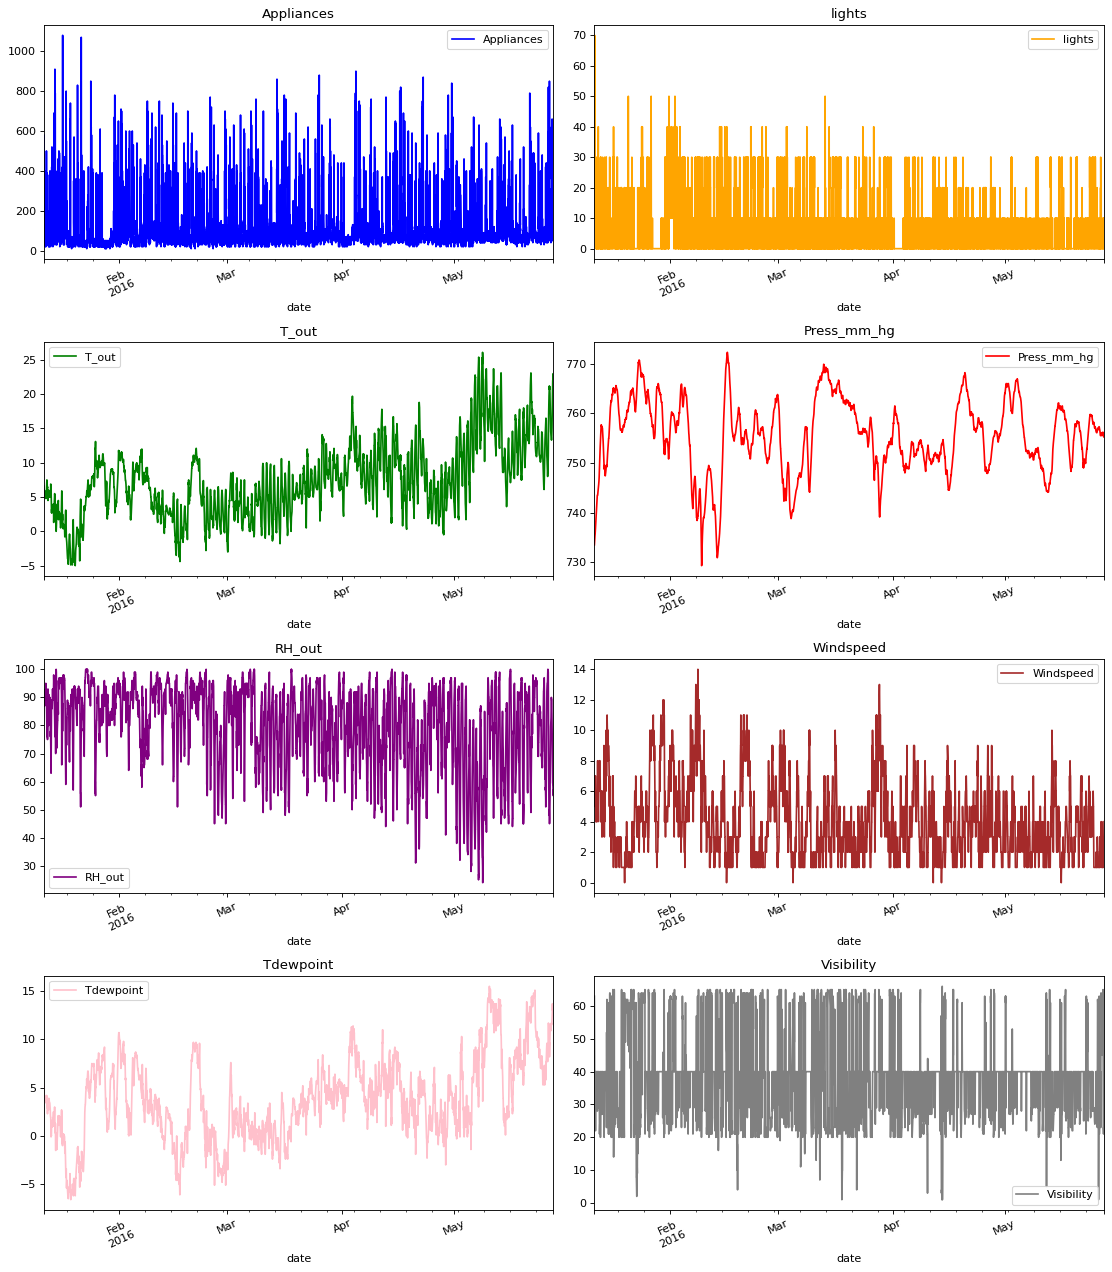

In [0]:
color_list = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

def Visualize(data):
    features= list(df.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)
    fig, axes = plt.subplots(
        nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(feature_size):
        key = features[i]
        c = color_list[i % (len(color_list))]
        t_data = data[key]
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(key),
            rot=25,
        )
        ax.legend([key])
    plt.tight_layout()

Visualize(df)

In [0]:
df[['Appliances','T_out','lights']].corr(method='spearman')

Out[5]:

,Appliances,T_out,lights
Appliances,1.000000,0.215504,0.302420
T_out,0.215504,1.000000,-0.072943
lights,0.302420,-0.072943,1.000000


Before we test Granger causality, we need to test stationarity first. We will employ the augmented Dickey-Fuller (ADF) test. The null hypothesis is that the time series possesses a unit root and hence is not stationary. The alternate hypothesis is that the series is stationary. The ADF statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.

In [0]:
result = adfuller(df['T_out'])
print(result)

(-7.3767068750756355, 8.684210164035494e-11, 45, 19689, {'1%': -3.430682172927125, '5%': -2.8616868086315823, '10%': -2.5668481422453397}, -55220.37416568599)

In [0]:
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critial Values: {result[4]}')
print('ADF Test Conclusion:')
if result[1] > 0.05 :
    print('- The time series has a unit root')
else:
    print('- The time series is stationary')

Test Statistics: -7.3767068750756355
p-value: 8.684210164035494e-11
Critial Values: {'1%': -3.430682172927125, '5%': -2.8616868086315823, '10%': -2.5668481422453397}
ADF Test Conclusion:
- The time series is stationary

Now that we know the time series we are interested in is stationary, let's do the Granger causality test:

   - \\(H_{0}\\): the series \\(z_{t}\\) does not Granger-causes \\(y_{t}\\)
   - \\(H_{1}\\): the series \\(z_{t}\\) Granger-causes \\(y_{t}\\)
   
Below the grangercausalitytests() function does the job. The argument \\(x\\) is the data for testing whether the time series in the second column Granger-causes the time series in the first column (note that missing values are not supported). The result of the test is a Python dictionary. Here, the dictionary keys are the number of lags. For each lag the values are wrapped in a tuple, with the first element a dictionary with test statistic, p-values, degrees of freedom, the second element are the OLS estimation results for the restricted model, the unrestricted model and the restriction (contrast) matrix for the parameter f_test.

In [0]:
max_lags=7 # a more rigorous way is to find the optimal lags in production but here we will set a large number just to test the concept

In [0]:
results=grangercausalitytests(x=df[['Appliances','T_out']], maxlag=max_lags, verbose=False) # we theorize that temperature (2nd column) can cause appliance usage (1st column) to spike
p_values=[round(results[i+1][0]['ssr_ftest'][1],max_lags) for i in range(max_lags)] # collecting p-values for each lag
print('P-values per lag: '+str(p_values)) # the result is [0,0,0,0] so there is Granger causality detected

P Values per lag: [5e-07, 0.0, 1e-07, 9e-07, 5e-06, 1.86e-05, 4.95e-05]

In [0]:
results

Out[25]: {1: ({'ssr_ftest': (10.53334835246853, 0.0011743499639564516, 19731.0, 1),
 'ssr_chi2test': (10.534949895474835, 0.0011713805807556563, 1),
 'lrtest': (10.532138867201866, 0.0011731636079150164, 1),
 'params_ftest': (10.533348353018786, 0.0011743499636064152, 19731.0, 1.0)},
 [<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f7e013ccf70>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f7e013cc3a0>,
 array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.8148797528074065, 0.022056625525238502, 19728.0, 2),
 'ssr_chi2test': (7.63169324433785, 0.022019064731783958, 2),
 'lrtest': (7.630217854399234, 0.02203531407785898, 2),
 'params_ftest': (3.8148797526774985, 0.022056625528065605, 19728.0, 2.0)},
 [<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f7e013cc0a0>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f7e011a82b0>,
 array([[0., 0., 1., 0., 0.],
 [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.3398191259642345, 0.07131403316203579, 19725.0, 3),
 'ssr_chi2test': (7.021948440080043, 0.07120148160269328, 3),
 'lrtest': (7.020699300279375, 0.071240933647145, 3),
 'params_ftest': (2.3398191260793815, 0.07131403315110686, 19725.0, 3.0)},
 [<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f7e013aca90>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f7e013cae80>,
 array([[0., 0., 0., 1., 0., 0., 0.],
 [0., 0., 0., 0., 1., 0., 0.],
 [0., 0., 0., 0., 0., 1., 0.]])]),
 4: ({'ssr_ftest': (1.7203434759463478, 0.1423383888892918, 19722.0, 4),
 'ssr_chi2test': (6.884514171767041, 0.14211843980084188, 4),
 'lrtest': (6.883313382655615, 0.14218457296329132, 4),
 'params_ftest': (1.720343475792042, 0.14233838892329947, 19722.0, 4.0)},
 [<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f7e013ca9d0>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f7e011aa460>,
 array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
 [0., 0., 0., 0., 0., 1., 0., 0., 0.],
 [0., 0., 0., 0., 0., 0., 1., 0., 0.],
 [0., 0., 0., 0., 0., 0., 0., 1., 0.]])]),
 5: ({'ssr_ftest': (1.265710173973144, 0.27559690816408655, 19719.0, 5),
 'ssr_chi2test': (6.332081173611779, 0.27523355041707803, 5),
 'lrtest': (6.331065293110441, 0.2753243356536228, 5),
 'params_ftest': (1.2657101740997518, 0.2755969081073115, 19719.0, 5.0)},
 [<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f7e011aaa00>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f7e011aa3a0>,
 array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
 [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
 [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
 [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])]),
 6: ({'ssr_ftest': (1.2745424812007695, 0.26515824458742177, 19716.0, 6),
 'ssr_chi2test': (7.652297203776624, 0.2646993490136604, 6),
 'lrtest': (7.650813537053182, 0.26481770812275135, 6),
 'params_ftest': (1.2745424811868702, 0.26515824459438964, 19716.0, 6.0)},
 [<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f7e011aac10>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f7e00c05520>,
 array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
 [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
 [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
 [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])]),
 7: ({'ssr_ftest': (1.7884589533554027, 0.0847932386320019, 19713.0, 7),
 'ssr_chi2test': (12.528738782659548, 0.08445766042365806, 7),
 'lrtest': (12.524762128989096, 0.084569548385559, 7),
 'params_ftest': (1.7884589534239532, 0.08479323861850702, 19713.0, 7.0)},
 [<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f7e00c05df0>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f7e00c05670>,
 array([[0

##### References:

   - https://github.com/srivatsan88/End-to-End-Time-Series/blob/master/Granger_Causality_Test_For_usefulness_of_TimeSeries_in_Forecasting.ipynb
   - https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html
   - https://www.ssc.wisc.edu/~bhansen/econometrics/